In [10]:
from sklearn.datasets import fetch_openml
import torch

mnist = fetch_openml('mnist_784', as_frame=False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
X = torch.from_numpy(mnist.data).float().to(device)
Y = torch.from_numpy(mnist.target.astype(int)).to(device)

In [23]:
from torch.utils.data import TensorDataset, DataLoader

split = int(len(X) * 6 / 7)

train_ds = TensorDataset(X[:split].view(-1, 1, 28, 28), Y[:split])
test_ds = TensorDataset(X[split:].view(-1, 1, 28, 28), Y[split:])
train_loader = DataLoader(train_ds, batch_size=6250)
test_loader = DataLoader(test_ds, batch_size=1250)

In [18]:
import torch.nn.functional as F
import torch.nn as nn

class MulticlassCCN(nn.Module):
    def __init__(self, c1=32, c2=64, fc_hidden=128, device=device):
        """
        c1: number of channels after first conv layer
        c2: number of channels after second conv layer
        fc_hidden: number of hidden units in the fully connected layer
        """
        super().__init__()
        self.conv1 = nn.Conv2d(1, c1, kernel_size=3, padding=1, device=device)
        self.conv2 = nn.Conv2d(c1, c2, kernel_size=3, padding=1, device=device)
        self.fc1 = nn.Linear(c2 * 7 * 7, fc_hidden, device=device)
        self.fc2 = nn.Linear(fc_hidden, 10, device=device)

    def forward(self, X):
        X = F.relu(self.conv1(X))       # (N, c1, 28, 28)
        X = F.max_pool2d(X, 2, 2)       # (N, c1, 14, 14)
        X = F.relu(self.conv2(X))       # (N, c2, 14, 14)
        X = F.max_pool2d(X, 2, 2)       # (N, c2, 7, 7)
        X = X.view(X.size(0), -1)       # flatten
        X = F.relu(self.fc1(X))         # (N, fc_hidden)
        X = self.fc2(X)                 # (N, 10)
        return X


In [29]:
model = MulticlassCCN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_error, test_error = [], []
epochs = 100

for i in range(epochs):
    model.train()
    total_train, num_batch = 0, 0
    for train_X, train_Y in train_loader:
        loss = criterion(model(train_X), train_Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train += loss.item()
        num_batch += 1
    total_train /= num_batch
    model.eval()
    total_test, num_batch = 0, 0
    with torch.no_grad():
        for test_X, test_Y in test_loader:
            total_test += criterion(model(test_X), test_Y).item()
            num_batch += 1
    total_test /= num_batch
    train_error.append(total_train)
    test_error.append(total_test)

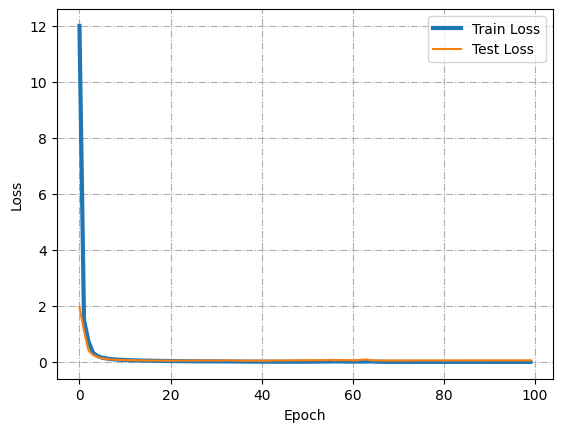

In [30]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), train_error, linewidth=3, label='Train Loss')
plt.plot(range(epochs), test_error, label='Test Loss')
plt.legend()
plt.grid(linestyle='-.')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [32]:
torch.save(model.state_dict(), '../inference/param/MNIST_CNN.pth')